# **Project Description**

A company producing fiber optic sensors decided to implement the concept
of Industry 4.0 in one of their production processes. They are going to
implement the AI techniques to automate verification of produced sensors.
Currently, after the production of the sensor, its characteristics should be
verified each time in three reference substances in order to configure:
● Air
● Water
● Isopropanol
After the procedure in the laboratory they collected three spectroscopic
signals. Unfortunately, such procedures are extremely time consuming and
require large human resources. Therefore they are planning to implement AI
algorithms in order to predict characteristics (or any other parameters – you
can propose something) of a working sensor in water and isopropanol based
on measured characteristics in air. It will enable to reduce validation process
only to measurements in the air, but other characteristics will be collected
based on the proposed model.

It's a collection of measurements based on 10 sensors . Each sensor was
measured three times(e.g.sensor01_air.txt, sensor01_water.txt, sensor01_izopropanol.txt). Each file
contains two-dimensional signal (signal



# **Goal**

Predict water and isopropanol characteristic based on signal wavelength and signal amplitude for air using AI.

#**1. Imports**

In [249]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **2. Data processing**

In [250]:
pd.options.display.float_format = '{:12.5e}'.format

In [251]:
# from google.colab import drive
# drive.mount('/content/drive')

In [252]:
path = "dataset" # Paste here data directory
sensors_list = os.listdir(path)

In [253]:
final_df = pd.DataFrame()
for idx, files in enumerate(sensors_list):
    if 'sesion' in files: #On some systems there is a problem with the ./DStore file this condition prevents errors from occurring.
        file = os.listdir(path+"/"+files)
        df = pd.DataFrame()
        iterator = 0
        for measure in file:
            a = pd.read_csv(path+"/"+files+"/"+measure,delimiter = ',',dtype=str,names=['lambda',measure[9:-4]])
            if iterator == 0:
                df = pd.concat([df,a])
            else:
                df = df.merge(a,how= 'inner', on='lambda')
            iterator =+ 1
        df['sensor'] = idx+1
        final_df = pd.concat([final_df,df]).reset_index(drop=True)
        final_df = final_df.astype(np.float32)

display(final_df.head())

,lambda,air,izopropanol,water,sensor
0,1.35000e-06,9.17920e+00,8.55510e+00,8.35700e+00,1.00000e+00
1,1.35010e-06,9.20030e+00,8.67500e+00,8.42870e+00,1.00000e+00
2,1.35020e-06,9.19680e+00,8.71160e+00,8.44220e+00,1.00000e+00
3,1.35030e-06,9.10280e+00,8.71570e+00,8.41440e+00,1.00000e+00
4,1.35040e-06,9.06010e+00,8.67920e+00,8.40340e+00,1.00000e+00


## **2.1 Data cleaning**

In [254]:
final_df.isna().sum()

lambda         0
air            0
izopropanol    0
water          0
sensor         0
dtype: int64

In [255]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30010 entries, 0 to 30009
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lambda       30010 non-null  float32
 1   air          30010 non-null  float32
 2   izopropanol  30010 non-null  float32
 3   water        30010 non-null  float32
 4   sensor       30010 non-null  float32
dtypes: float32(5)
memory usage: 586.3 KB


In [256]:
features = ['lambda', 'air', 'izopropanol', 'water']

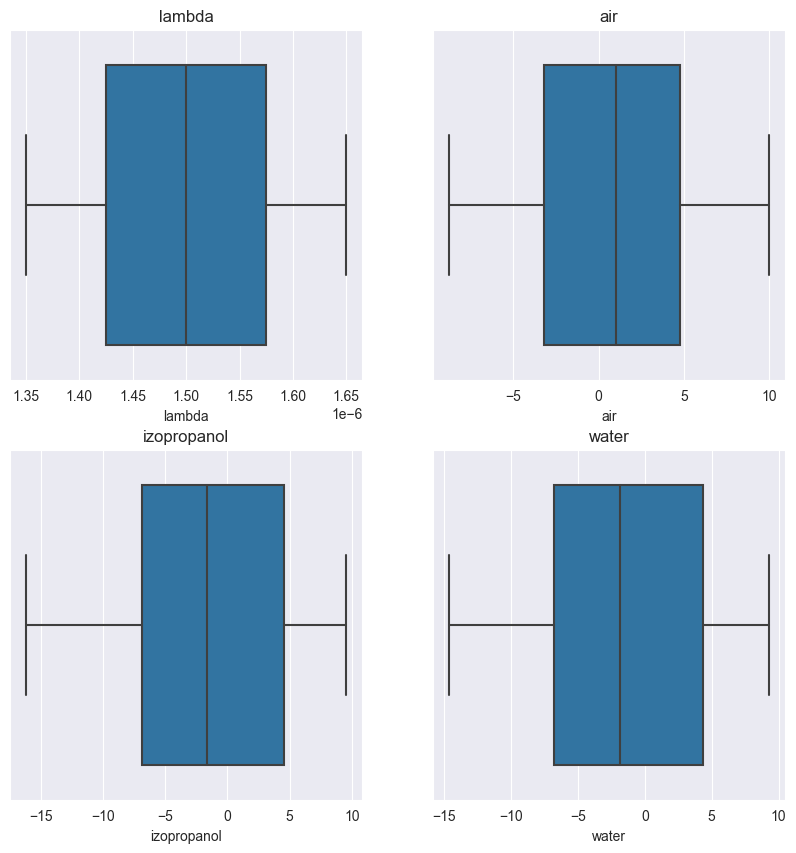

In [257]:
plt.figure(figsize = (10,10))
for i, feature in enumerate(features):
    plt.subplot(2,2,i+1)
    sns.boxplot(x = final_df[feature])
    plt.title(feature)

## **2.2 Data visualization**

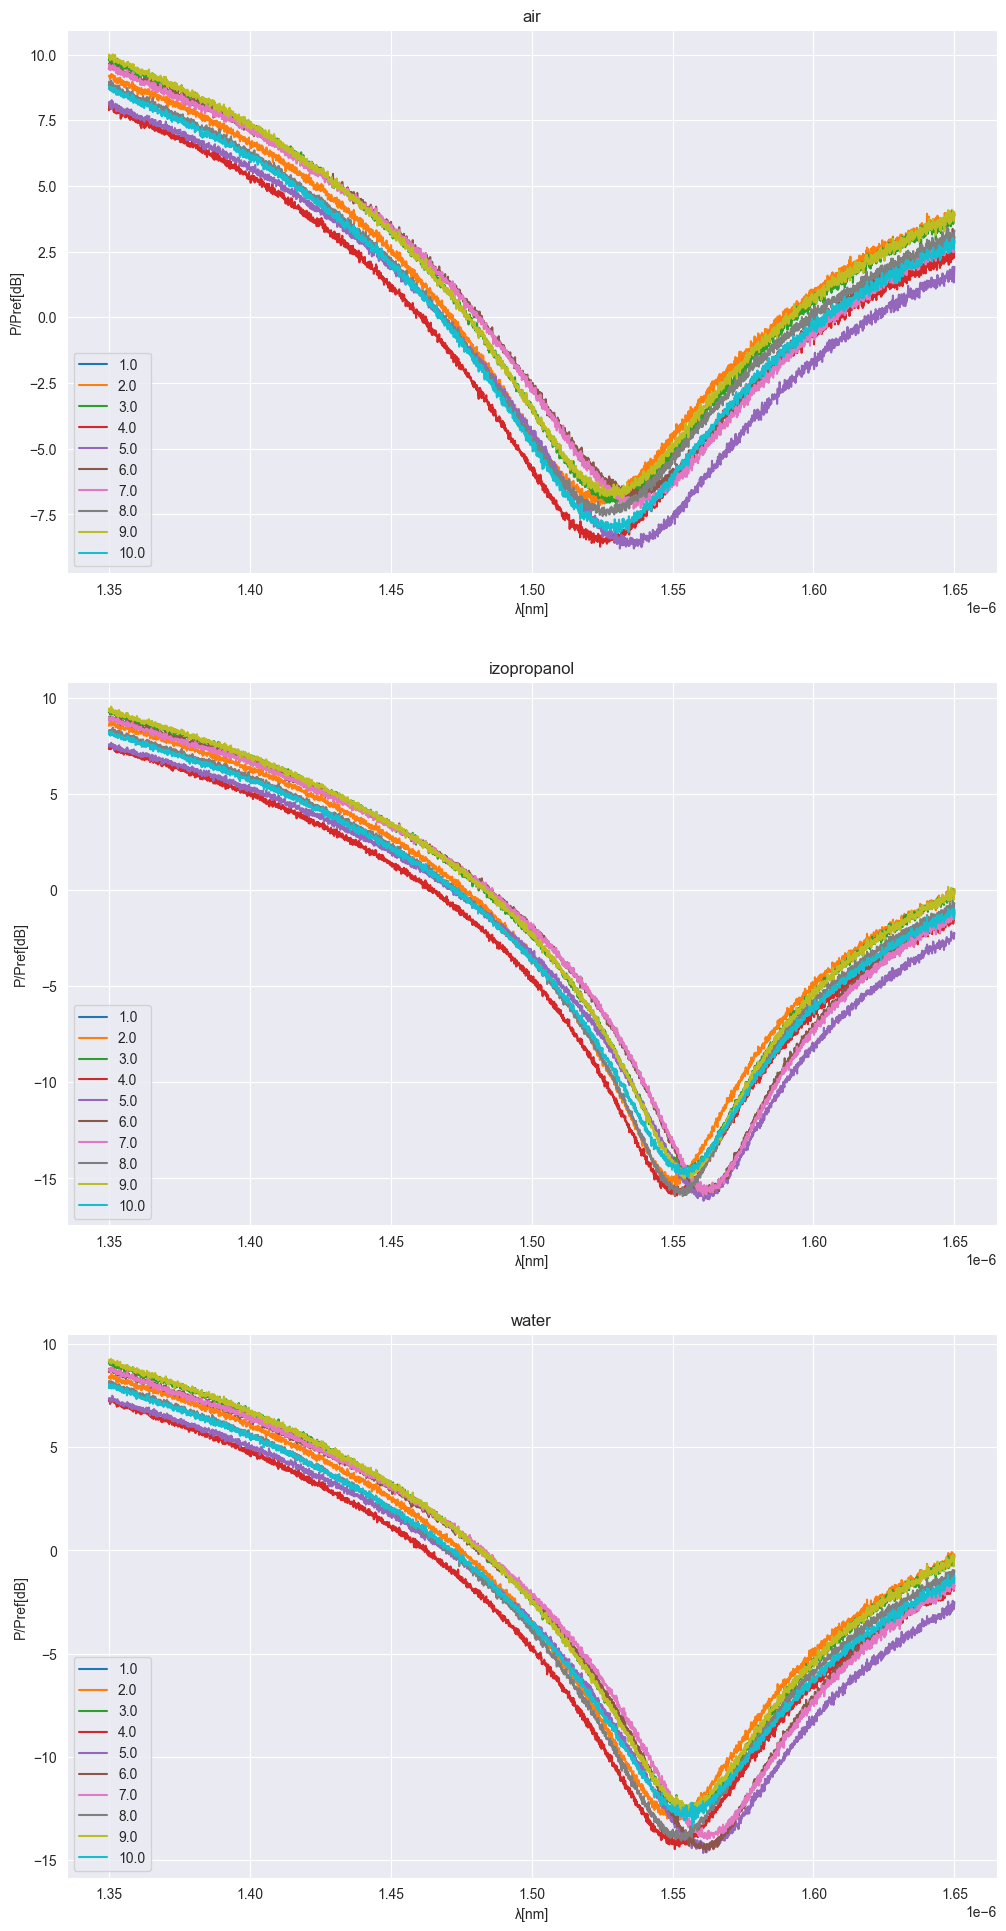

In [258]:
fig, axs = plt.subplots(3,1,figsize=(12, 24))
for idx, column in enumerate(final_df.iloc[:,1:-1].columns):
    for i in range(final_df['sensor'].drop_duplicates().shape[0]):
        one_sensor_data = final_df[final_df['sensor'] == i]
        axs[idx].plot(one_sensor_data['lambda'],one_sensor_data[column])
        axs[idx].set_title(column)
        axs[idx].legend(final_df['sensor'].drop_duplicates())
        axs[idx].set_xlabel('λ[nm]')
        axs[idx].set_ylabel('P/Pref[dB]')
plt.show()

**Data looks realy clear there is no ```nan``` and outliers**



<AxesSubplot: >

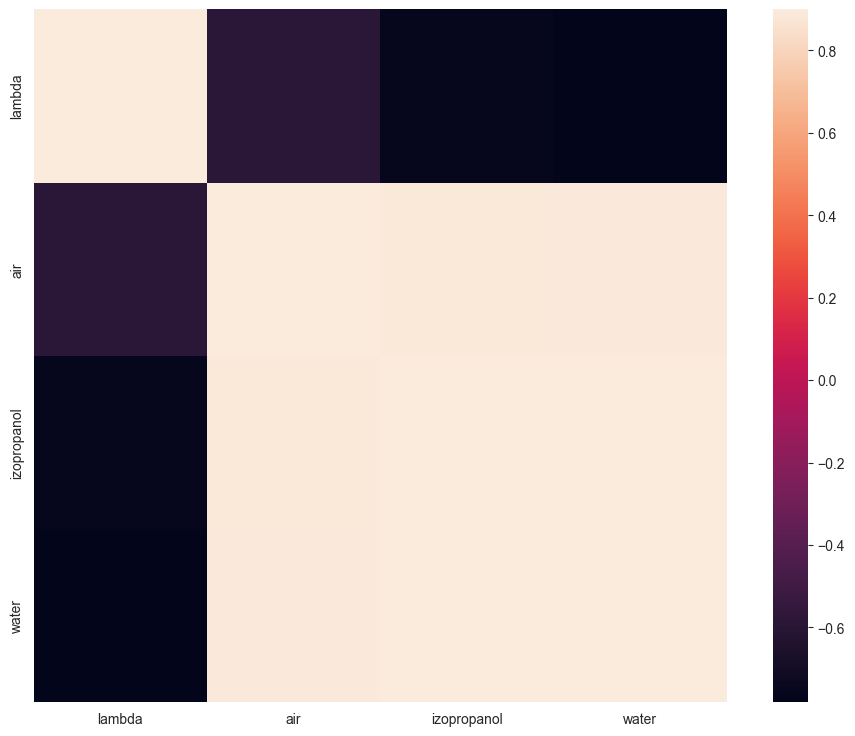

In [259]:
corrmat = final_df[features].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

**All features are highly correlated it means prediction should take high scores. There is no necessary data transformation and feature extraction we can move forward.**

## **2.3 Data splitting**

**Since the prediction model will be used to predict a specific sensor, I decided not to use `train_test_split` from the scikit-learn library, but do split the data manually and take only one sensor for the test set, as will be done in production.**

In [260]:
X_test = final_df[final_df['sensor'] == 1].loc[:,['lambda', 'air']]
X_val = final_df[final_df['sensor'] == 2].loc[:,['lambda', 'air']]
X_train = final_df[final_df['sensor'] > 2].loc[:,['lambda', 'air']]
y_test_water = final_df[final_df['sensor'] == 1].loc[:,['water']]
y_val_water = final_df[final_df['sensor'] == 2].loc[:,['water']]
y_train_water = final_df[final_df['sensor'] > 2].loc[:,['water']]
y_test_izopropanol = final_df[final_df['sensor'] == 1].loc[:,['izopropanol']]
y_val_izopropanol = final_df[final_df['sensor'] == 2].loc[:,['izopropanol']]
y_train_izopropanol = final_df[final_df['sensor'] > 2].loc[:,['izopropanol']]

In [261]:
y_val_izopropanol

,izopropanol
3001,9.25440e+00
3002,9.30120e+00
3003,9.25120e+00
3004,9.27340e+00
3005,9.19990e+00
...,...
5997,-3.94290e-01
5998,-2.15570e-01
5999,-2.96660e-01
6000,-1.17730e-01


In [262]:
final_df

,lambda,air,izopropanol,water,sensor
0,1.35000e-06,9.17920e+00,8.55510e+00,8.35700e+00,1.00000e+00
1,1.35010e-06,9.20030e+00,8.67500e+00,8.42870e+00,1.00000e+00
2,1.35020e-06,9.19680e+00,8.71160e+00,8.44220e+00,1.00000e+00
3,1.35030e-06,9.10280e+00,8.71570e+00,8.41440e+00,1.00000e+00
4,1.35040e-06,9.06010e+00,8.67920e+00,8.40340e+00,1.00000e+00
...,...,...,...,...,...
30005,1.64960e-06,3.27840e+00,-6.14780e-01,-8.65650e-01,1.00000e+01
30006,1.64970e-06,3.42130e+00,-5.36290e-01,-8.44350e-01,1.00000e+01
30007,1.64980e-06,3.31120e+00,-8.18380e-01,-9.73830e-01,1.00000e+01
30008,1.64990e-06,3.45000e+00,-5.72020e-01,-6.38490e-01,1.00000e+01


## **2.4 Data normalization**

In [263]:
scaler_standard = StandardScaler()
X_train = scaler_standard.fit_transform(X_train)
X_test = scaler_standard.transform(X_test)
X_val = scaler_standard.transform(X_val)

# **3. Models**

The algorithms it will use:


*   LinearRegression
*   DecisionTreeRegressor
*   SVR
*   XGBoostRegressor

Two neural networks:


*   Custom Neural Network
*   MLPRegressor




## **3.1 Machine learning algorithms**

### **3.1.1 LinearRegression**

In [264]:
lr = LinearRegression()

In [265]:
lr_water = lr.fit(X_train, y_train_water)
y_pred_lr_water = lr_water.predict(X_test)

In [266]:
lr_izopropanol = lr.fit(X_train, y_train_izopropanol)
y_pred_lr_izopropanol = lr_izopropanol.predict(X_test)

In [267]:
preds = [y_pred_lr_water, y_pred_lr_izopropanol]

In [268]:
def plot_real_and_predicted(preds):
  tests = [y_test_water, y_test_izopropanol]
  columns = ['Water', 'Izopropanol']
  fig, axs = plt.subplots(2,1,figsize=(12, 24))
  for idx, pred in enumerate(preds):
    axs[idx].plot(X_test[:,0],pred, color='red', label='Predicted')
    axs[idx].plot(X_test[:,0],tests[idx], color='blue', label='Real')
    axs[idx].set_title(columns[idx])
    axs[idx].set_xlabel('λ[nm]')
    axs[idx].set_ylabel('P/Pref[dB]')
    axs[idx].legend()

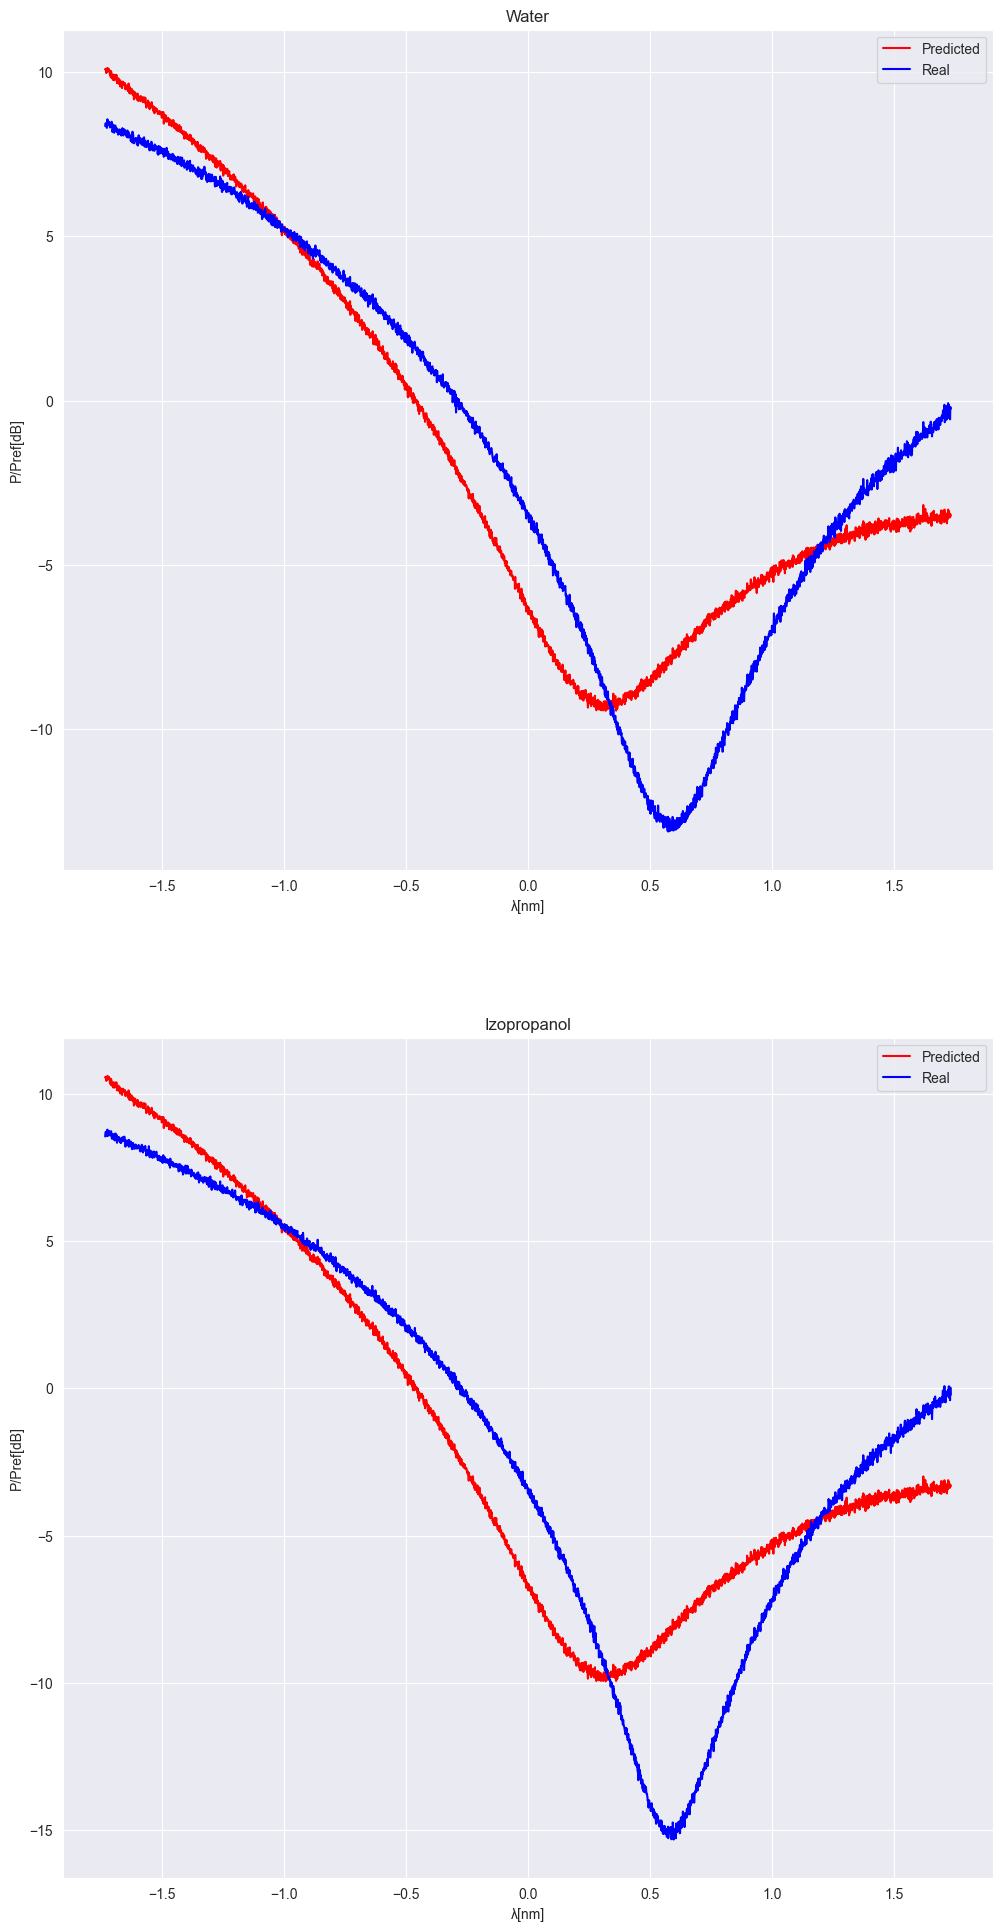

In [269]:
plot_real_and_predicted(preds)

In [270]:
def evaluate_model(real, pred):
  print(real.columns[0])
  print('R^2: ',r2_score(real, pred))
  print('MAE: ',mean_absolute_error(real, pred))
  print('MSE: ',mean_squared_error(real, pred))
  mets = [r2_score(real, pred), mean_absolute_error(real, pred), mean_squared_error(real, pred)]
  return mets

In [271]:
lr_water_mets = evaluate_model(y_test_water, y_pred_lr_water)

water
R^2:  0.8810765930068896
MAE:  1.7665017
MSE:  4.8199277


In [272]:
lr_izopropanol_mets = evaluate_model(y_test_izopropanol, y_pred_lr_izopropanol)

izopropanol
R^2:  0.8530203930088562
MAE:  2.0547948
MSE:  6.9262056


### **3.1.2 DecisionTreeRegressor**

In [273]:
dtr = DecisionTreeRegressor(criterion='friedman_mse', random_state=0)

In [274]:
dtr.fit(X_train, y_train_water)
y_pred_dtr_water = dtr.predict(X_test)

In [275]:
dtr.fit(X_train, y_train_izopropanol)
y_pred_dtr_izopropanol = dtr.predict(X_test)

In [276]:
preds = [y_pred_dtr_water, y_pred_dtr_izopropanol]

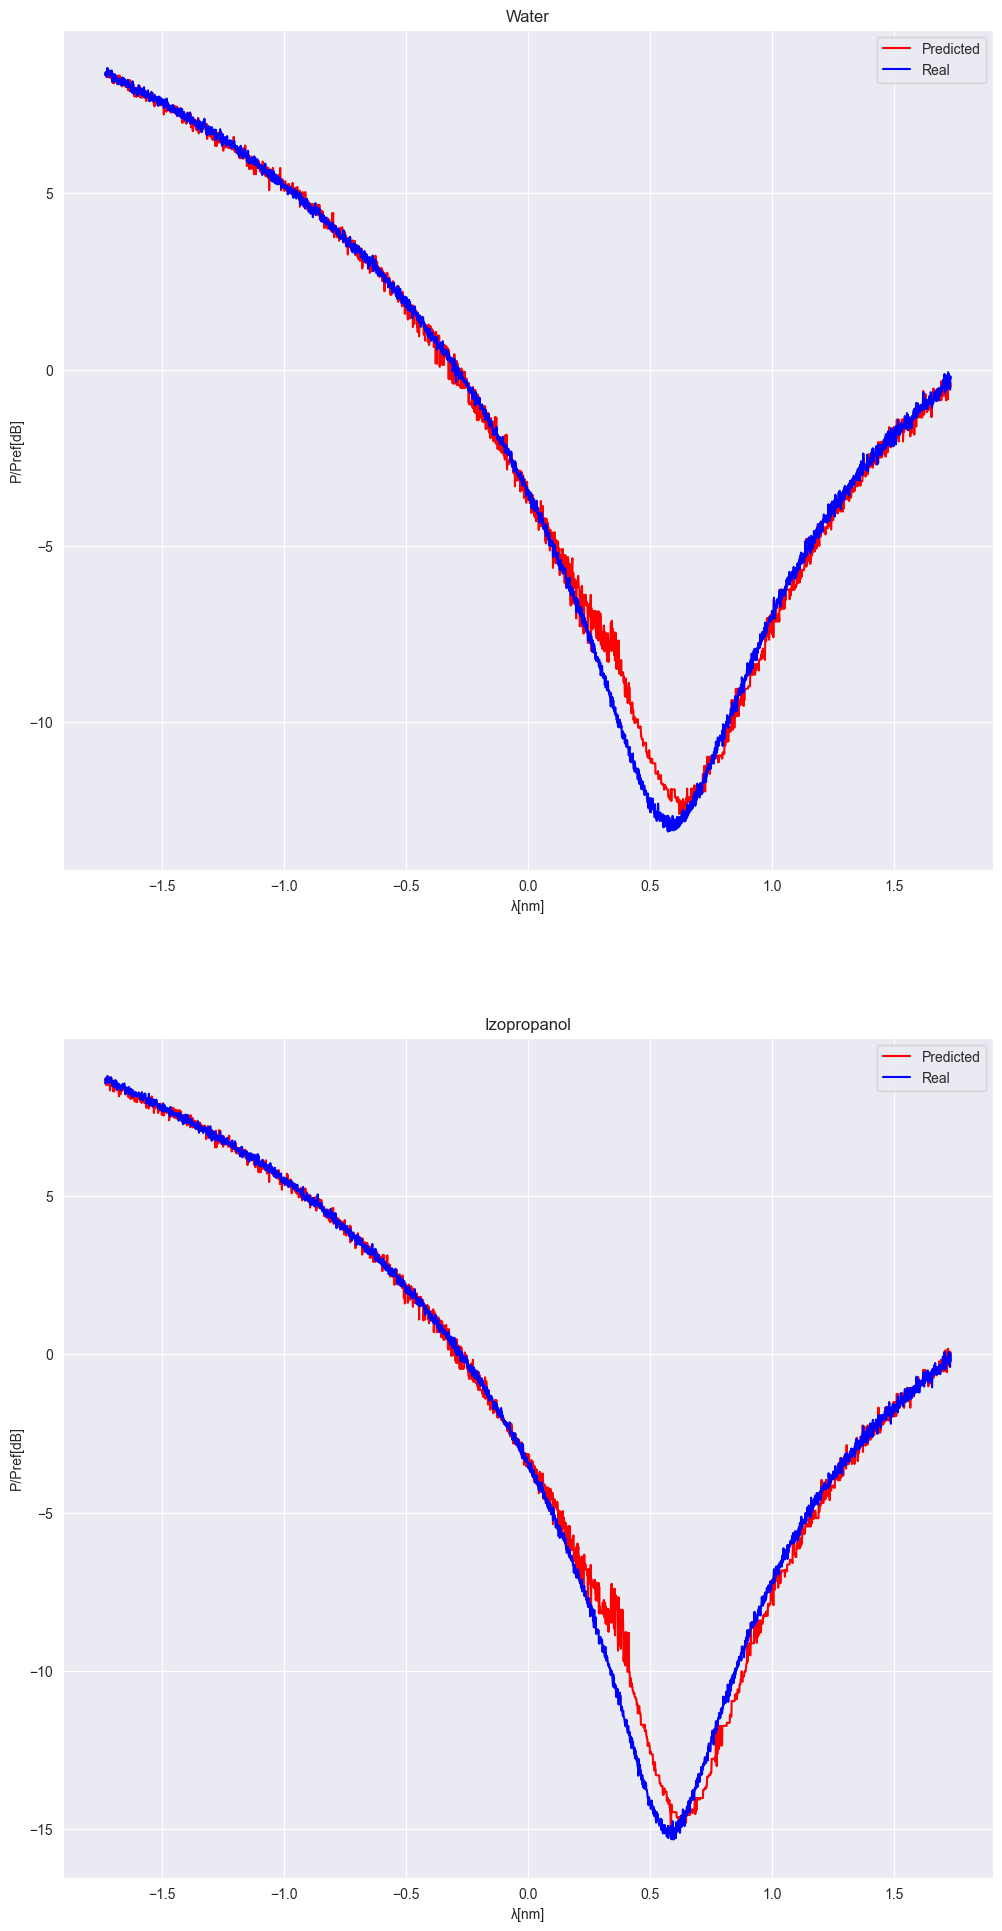

In [277]:
plot_real_and_predicted(preds)

In [278]:
dtr_water_mets = evaluate_model(y_test_water, y_pred_dtr_water)

water
R^2:  0.994256241074239
MAE:  0.2941683358225757
MSE:  0.23279271960600437


In [279]:
dtr_izopropanol_mets = evaluate_model(y_test_izopropanol, y_pred_dtr_izopropanol)

izopropanol
R^2:  0.9915866816523575
MAE:  0.36670626572755954
MSE:  0.39646568885957906


### **3.1.3 SVR**

In [280]:
svr = SVR(kernel="rbf", C=1,epsilon= 0.1,coef0=0.1,degree=2)

In [281]:
svr.fit(X_train, y_train_water)
y_pred_svr_water = svr.predict(X_test)

C:\Users\przem\IdeaProjects\ai-for-the-industry-4.0\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [282]:
svr.fit(X_train, y_train_izopropanol)
y_pred_svr_izopropanol = svr.predict(X_test)

C:\Users\przem\IdeaProjects\ai-for-the-industry-4.0\venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [283]:
preds = [y_pred_svr_water, y_pred_svr_izopropanol]

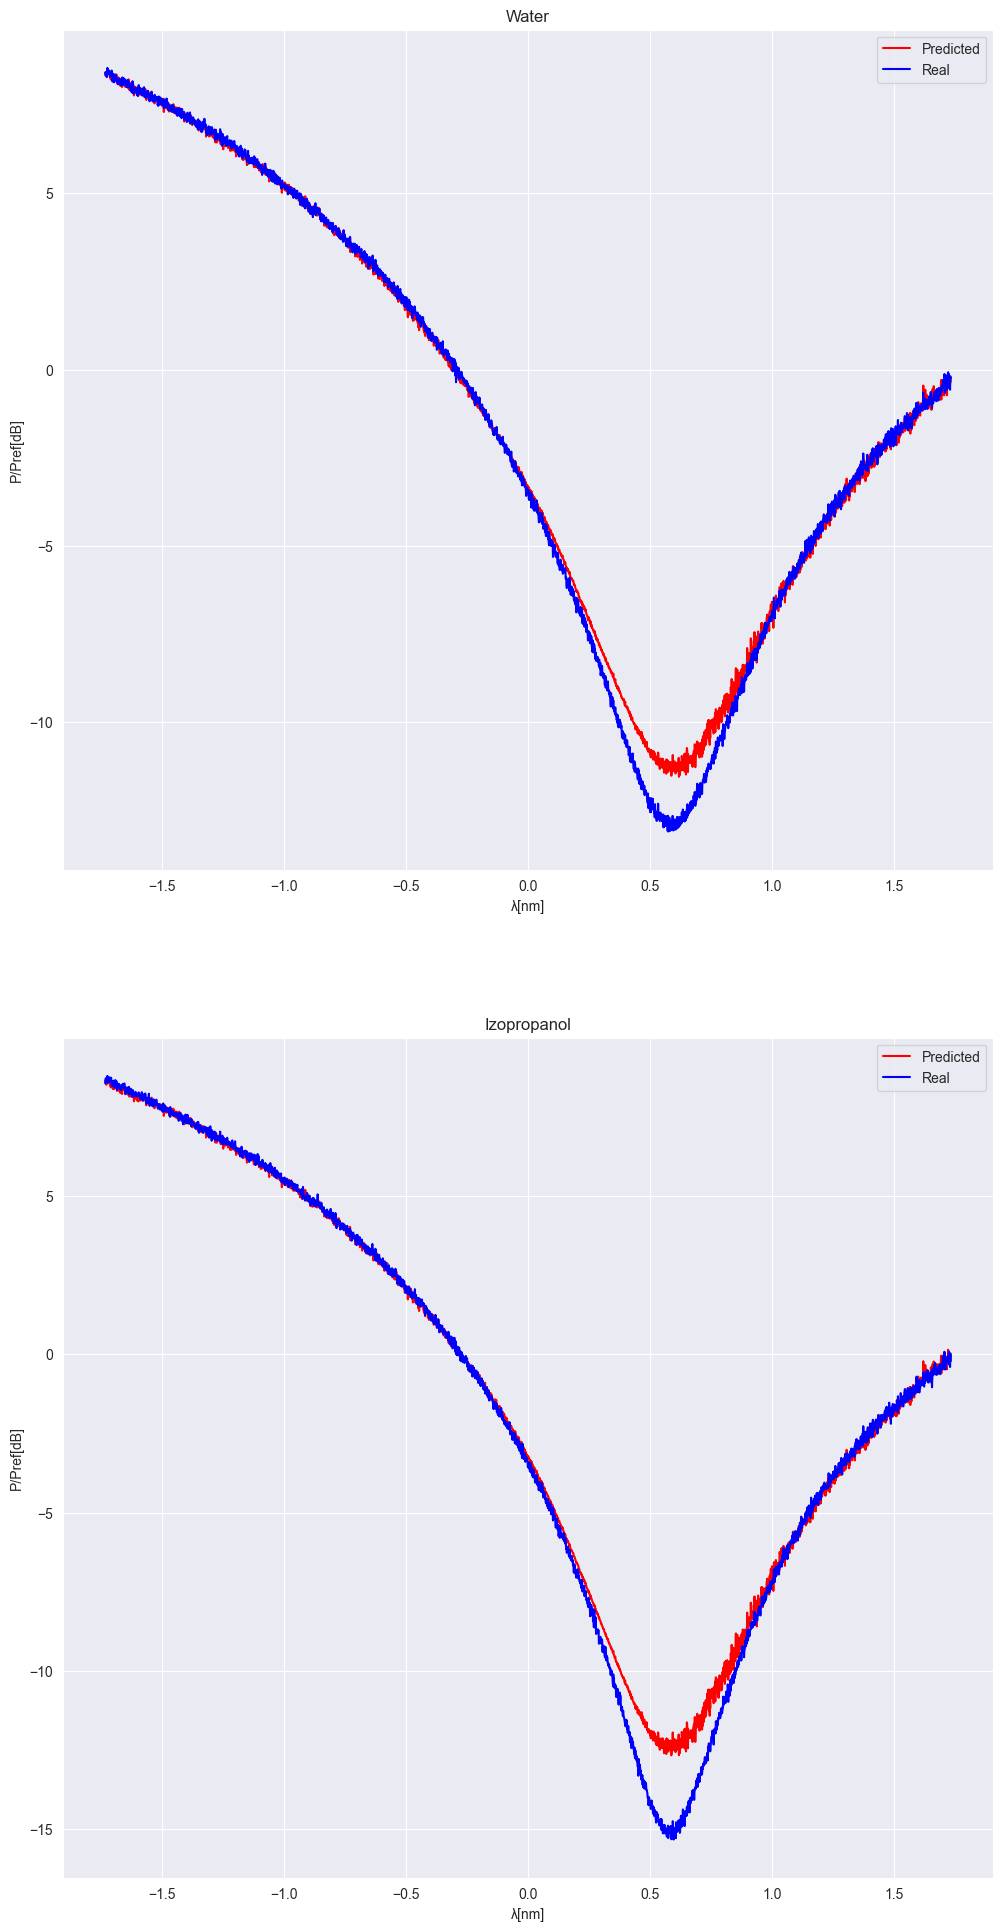

In [284]:
plot_real_and_predicted(preds)

In [285]:
svr_water_mets = evaluate_model(y_test_water, y_pred_svr_water)

water
R^2:  0.9937278130461528
MAE:  0.28758933817561955
MSE:  0.2542097392553698


In [286]:
svr_izopropanol_mets = evaluate_model(y_test_izopropanol, y_pred_svr_izopropanol)

izopropanol
R^2:  0.9884296330176026
MAE:  0.3711354269714204
MSE:  0.5452371260050766


### **3.1.4 XGBoostRegressor**

In [287]:
xgbr = xgb.XGBRegressor()

In [288]:
xgbr.fit(X_train, y_train_water)
y_pred_xgbr_water = xgbr.predict(X_test)

In [289]:
xgbr.fit(X_train, y_train_izopropanol)
y_pred_xgbr_izopropanol = xgbr.predict(X_test)

In [290]:
preds = [y_pred_xgbr_water, y_pred_xgbr_izopropanol]

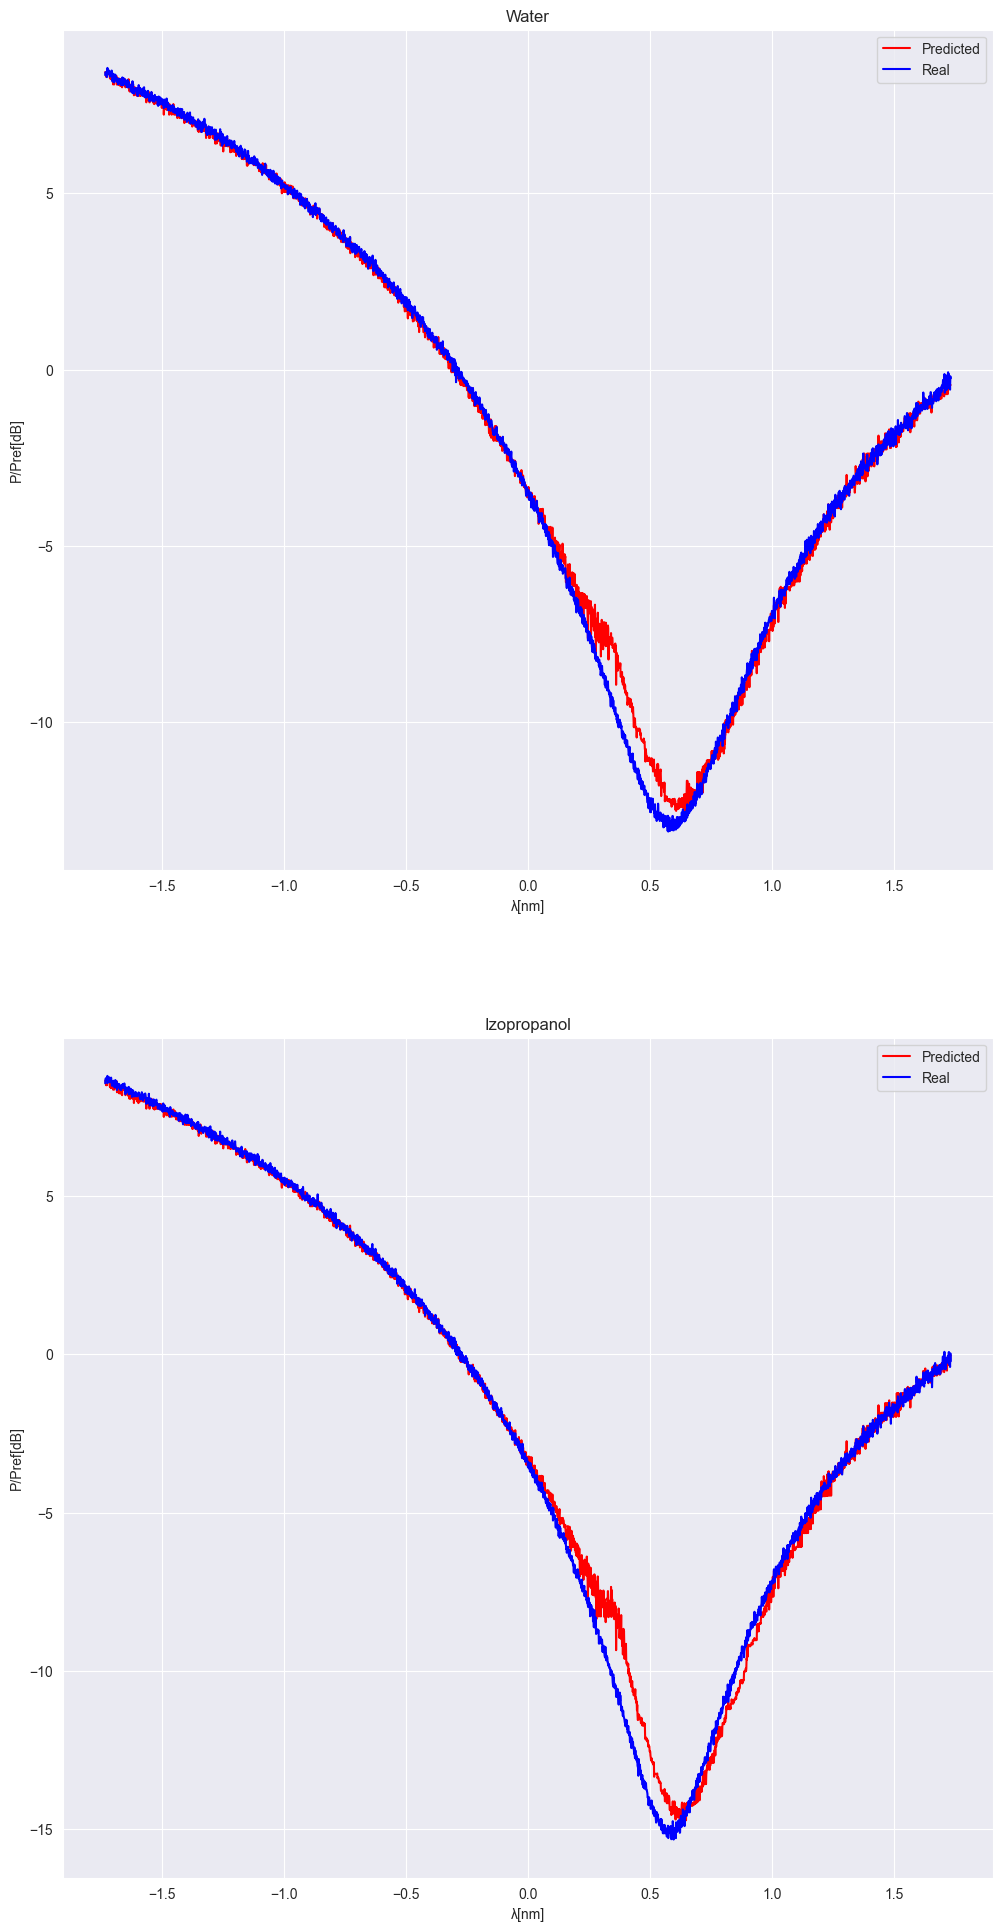

In [291]:
plot_real_and_predicted(preds)

In [292]:
xgbr_water_mets = evaluate_model(y_test_water, y_pred_xgbr_water)

water
R^2:  0.9952688718942522
MAE:  0.24960418
MSE:  0.19175112


In [293]:
xgbr_izopropanol_mets = evaluate_model(y_test_izopropanol, y_pred_xgbr_izopropanol)

izopropanol
R^2:  0.9926456076131025
MAE:  0.3260039
MSE:  0.3465653


## **3.2 Neural Networks**

### **3.2.1 Custom Neural Network**

In [294]:
model_water = Sequential()
model_water.add(Dense(32, input_dim=X_train.shape[1], activation='tanh'))
model_water.add(Dense(32, activation='tanh'))
model_water.add(Dense(y_train_water.shape[1]))

In [295]:
model_water.compile(loss=['mean_squared_error'], optimizer='Adam')

In [296]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)

In [297]:
history = model_water.fit(X_train, y_train_water, epochs=100, batch_size=16, validation_data=(X_val, y_val_water), callbacks=[early_stop, checkpoint])
y_pred_cnn_water = model_water.predict(X_test)

Epoch 1/100
1501/1501 [==============================] - 2s 1ms/step - loss: 3.3718 - val_loss: 0.1775
Epoch 2/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.2108 - val_loss: 0.0944
Epoch 3/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1655 - val_loss: 0.0563
Epoch 4/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1550 - val_loss: 0.1195
Epoch 5/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1512 - val_loss: 0.0265
Epoch 6/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1486 - val_loss: 0.0531
Epoch 7/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1457 - val_loss: 0.0759
Epoch 8/100
94/94 [==============================] - 0s 810us/step


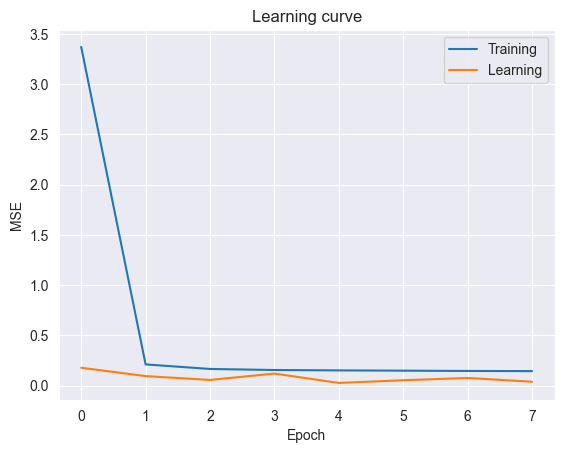

In [298]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Learning'], loc='upper right')
plt.show()

In [299]:
model_izopropanol = Sequential()
model_izopropanol.add(Dense(32, input_dim=X_train.shape[1], activation='tanh'))
model_izopropanol.add(Dense(32, activation='tanh'))
model_izopropanol.add(Dense(y_train_water.shape[1]))

In [300]:
model_izopropanol.compile(loss=['mean_squared_error'], optimizer='Adam')

In [301]:
history = model_izopropanol.fit(X_train, y_train_izopropanol, epochs=100, batch_size=16, validation_data=(X_val, y_val_izopropanol), callbacks=[early_stop, checkpoint])
y_pred_cnn_izopropanol = model_izopropanol.predict(X_test)

Epoch 1/100
1501/1501 [==============================] - 2s 1ms/step - loss: 4.0523 - val_loss: 0.2416
Epoch 2/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.2904 - val_loss: 0.0576
Epoch 3/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.2420 - val_loss: 0.0503
Epoch 4/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.2252 - val_loss: 0.0968
Epoch 5/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.2135 - val_loss: 0.0309
Epoch 6/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.2060 - val_loss: 0.0262
Epoch 7/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1998 - val_loss: 0.0486
Epoch 8/100
1501/1501 [==============================] - 2s 1ms/step - loss: 0.1972 - val_loss: 0.0274
Epoch 9/100
94/94 [==============================] - 0s 856us/step


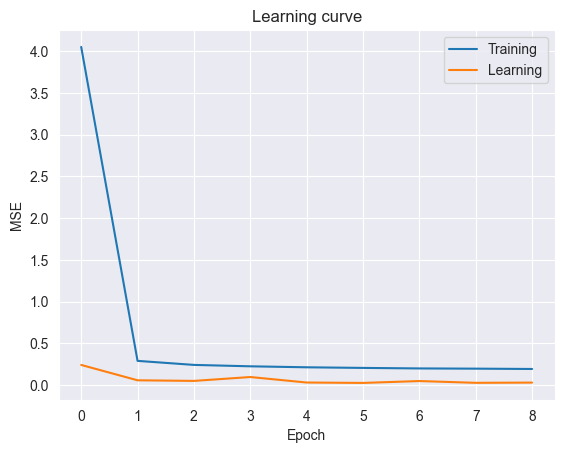

In [302]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Learning'], loc='upper right')
plt.show()

In [303]:
preds=[y_pred_cnn_water, y_pred_cnn_izopropanol]

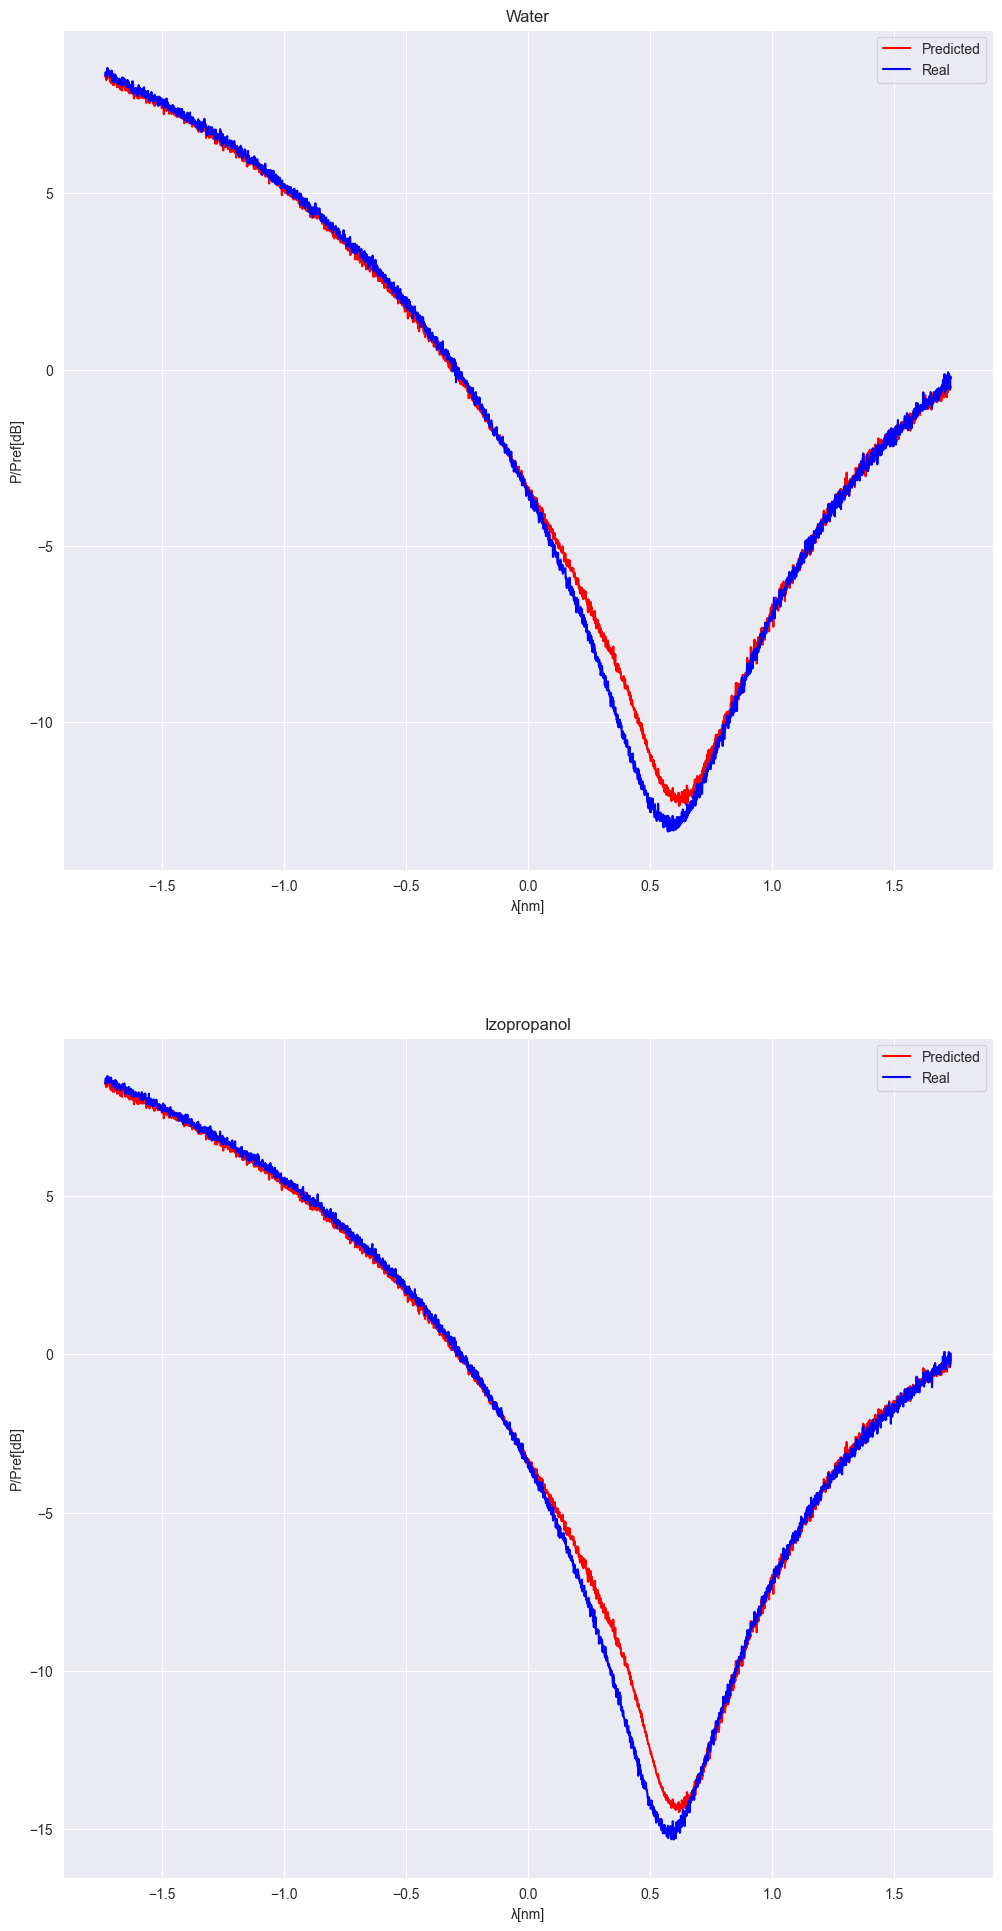

In [304]:
plot_real_and_predicted(preds)

In [305]:
cnn_water_mets = evaluate_model(y_test_water, y_pred_cnn_water)

water
R^2:  0.9947565007567397
MAE:  0.2671071
MSE:  0.21251735


In [306]:
cnn_izopropanol_mets = evaluate_model(y_test_izopropanol, y_pred_cnn_izopropanol)

izopropanol
R^2:  0.9941051293371619
MAE:  0.29106504
MSE:  0.27778742


### **3.2.2 MLPRegressor**

In [307]:
mlpr_water = MLPRegressor(hidden_layer_sizes = (8,4,4,2), activation = "tanh", random_state = 2, max_iter = 400,
                         solver="adam",batch_size=16)

In [308]:
mlpr_water.fit(X_train, y_train_water)
y_pred_mlpr_water = mlpr_water.predict(X_test)

C:\Users\przem\IdeaProjects\ai-for-the-industry-4.0\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


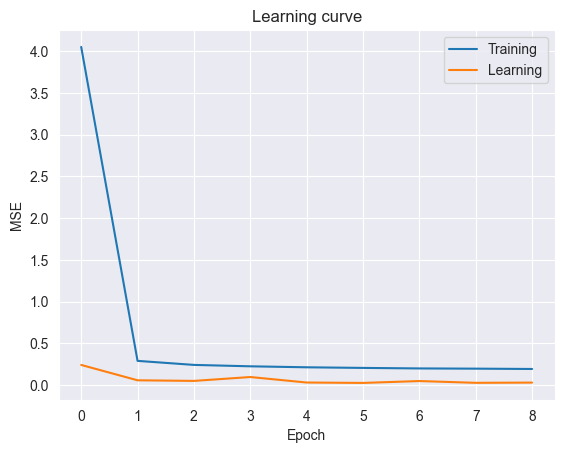

In [309]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Learning'], loc='upper right')
plt.show()

In [310]:
mlpr_izopropanol = MLPRegressor(hidden_layer_sizes = (8,4,4,2), activation = "tanh", random_state = 2, max_iter = 400,
                          solver="adam",batch_size=16)

In [311]:
mlpr_izopropanol.fit(X_train, y_train_izopropanol)
y_pred_mlpr_izopropanol = mlpr_izopropanol.predict(X_test)

C:\Users\przem\IdeaProjects\ai-for-the-industry-4.0\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


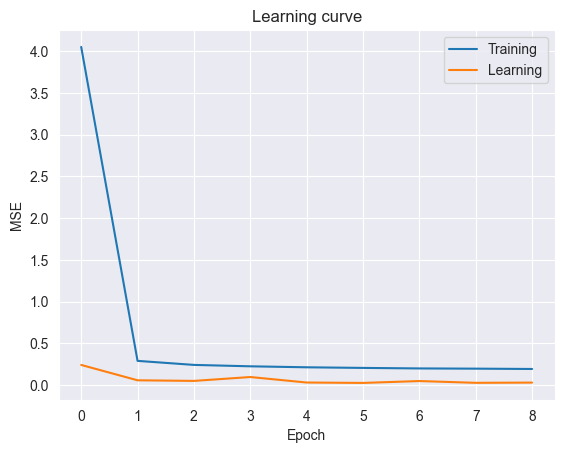

In [312]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Learning'], loc='upper right')
plt.show()

In [313]:
preds=[y_pred_mlpr_water, y_pred_mlpr_izopropanol]

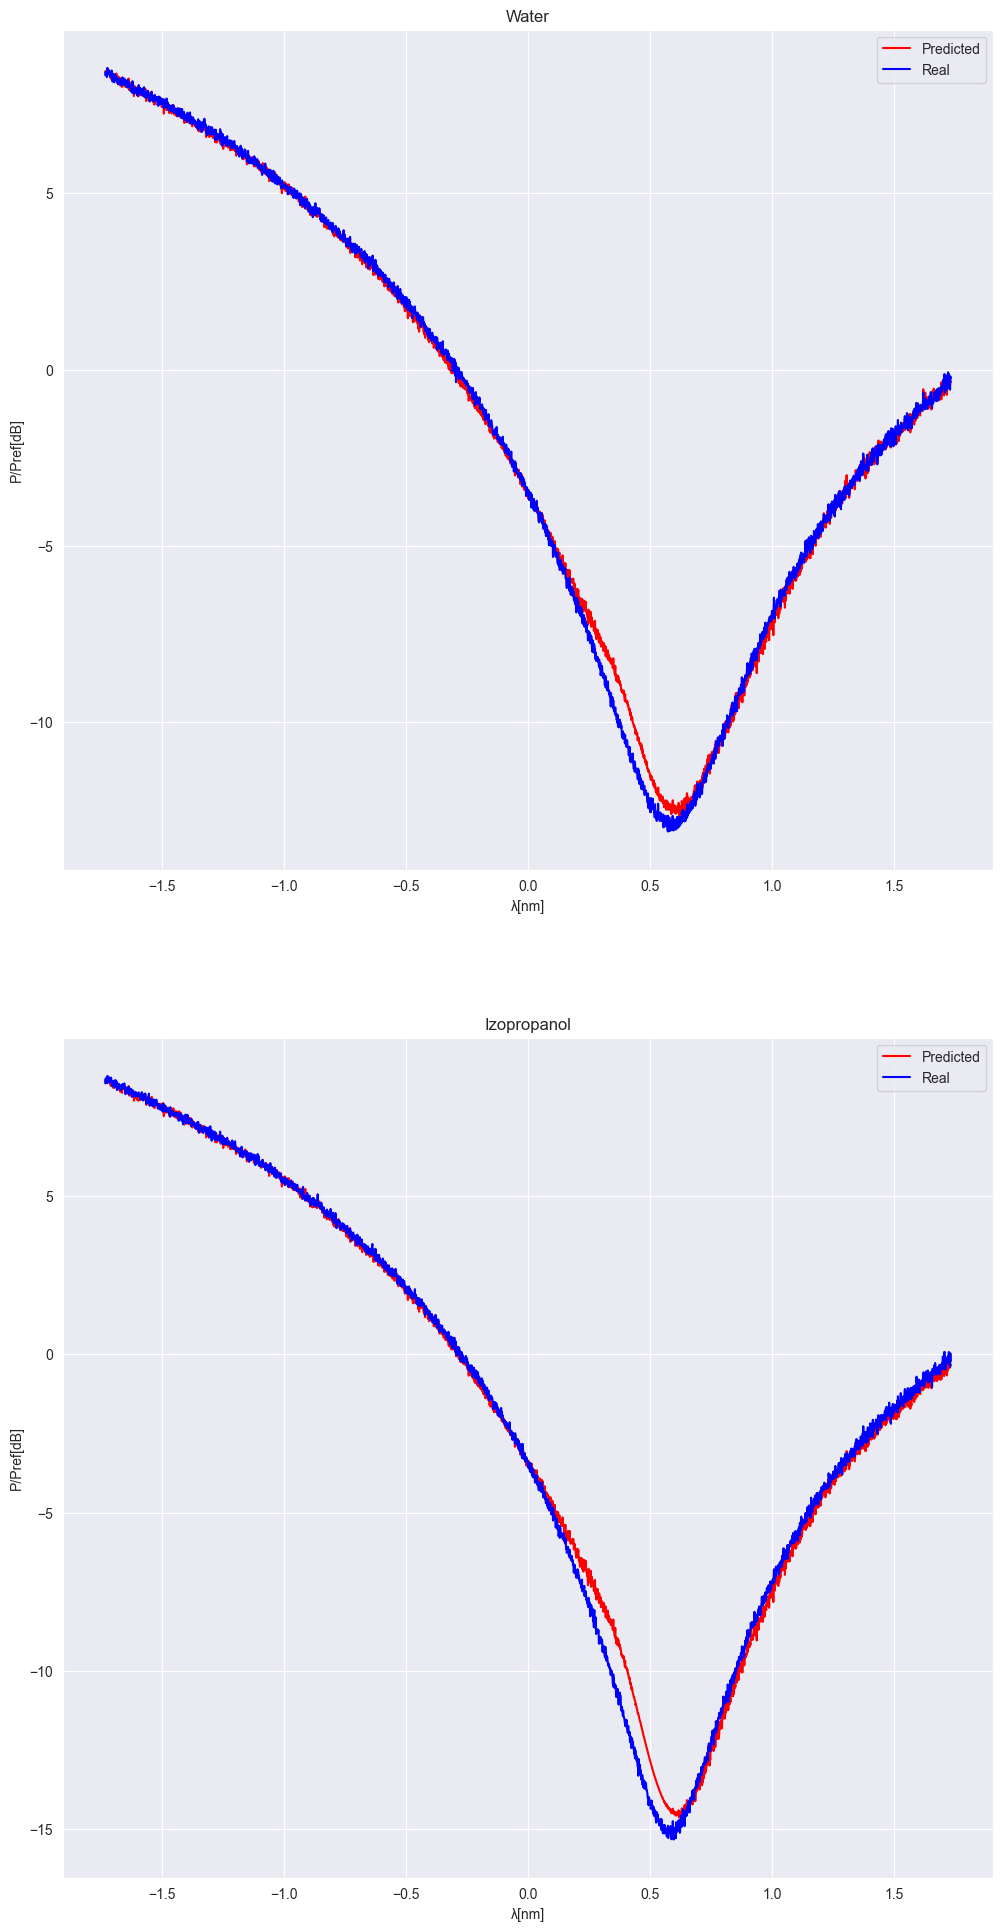

In [314]:
plot_real_and_predicted(preds)

In [315]:
mlpr_water_mets = evaluate_model(y_test_water, y_pred_mlpr_water)

water
R^2:  0.9974221309459201
MAE:  0.19749996
MSE:  0.10448021


In [316]:
mlpr_izopropanol_mets = evaluate_model(y_test_izopropanol, y_pred_mlpr_izopropanol)

izopropanol
R^2:  0.994945855937587
MAE:  0.28059733
MSE:  0.23816933


In conclusion, the use of regression algorithms was successful in predicting the characteristics of sensors in water and isopropanol based on measurements taken in air. With a high R^2 value and low MAE and MSE values, the model demonstrated a strong linear relationship between air and izopropanol/water characteristics. This can greatly improve the production process by reducing the amount of time and resources required for validation. This is just a preliminary analysis and further experimentation can be done to improve the accuracy of the model.